### Volatility Modeling, Master Mathematics for Finance and Data (MFD), Ecole des Ponts ParisTech and Université Gustave Eiffel, 2023-24
# Optional computing homework

In [1]:
import numpy as np

from scipy.stats import norm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4.8, 3.2)

from math import exp, sqrt, log, pi, sin, cos, atan, tan

In [2]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   #a better imp vol estimator based on P Jäckel Let's be rational

# The two-factor Bergomi model
The objective of the homework is to price SPX options, VIX futures, and VIX options in the two-factor Bergomi model

\begin{eqnarray}
S_t &=& S_0 \exp\left(\int_0^t \sqrt{\xi_s^s}dW_s - \frac{1}{2}\int_0^t \xi_s^s ds \right) \\
    X_t^j &=& e^{-k_j t} \int_0^t e^{k_j s} \, dZ^j_s, \qquad j\in\{1,2\} \\
\alpha_\theta &=& \left( (1-\theta)^2 +\theta^2+2 \rho_{12}\theta(1-\theta)\right)^{-1/2} \\
x_t^u &=& \alpha_\theta \left((1-\theta)e^{-k_1(u-t)}X_t^1 + \theta e^{-k_2(u-t)}X_t^2 \right) \\
\xi_t^u &=& \xi_0^u g^u(t,x_t^u) \;\; = \;\;\xi_0^u f^u(t,X_t^1,X_t^2) \\
g^u(t,x) &=& \exp\left(\omega x - \frac{\omega^2}{2}\chi(t,u)\right) \\
\chi(t,u) &=& \alpha_\theta^2\left( (1-\theta)^2e^{-2k_1(u-t)} \text{Var}(X_t^1) + \theta^2e^{-2k_2(u-t)} \text{Var}(X_t^2) \right. \\
&& \left. + 2\theta(1-\theta)e^{-(k_1+k_2)(u-t)}\text{Cov}(X_t^1,X_t^2)\right) \\
d\langle W,Z^1\rangle_t &=& \rho_{S1} dt \\
d\langle W,Z^2\rangle_t &=& \rho_{S2} dt \\
d\langle Z^1,Z^2\rangle_t &=& \rho_{12} dt \\
\end{eqnarray}

## Pricing SPX options

By doing a Cholesky decomposition, give a necessary and sufficient condition (*) on $\rho_{S1},\rho_{S2},\rho_{12}$ so that
$$\begin{bmatrix}1 & \rho_{S1} & \rho_{S2}\\ \rho_{S1} & 1 & \rho_{12} \\ \rho_{S2} & \rho_{12} & 1\end{bmatrix}$$
is a correlation matrix.

Below we describe a Monte Carlo simulation scheme for the two-factor Bergomi model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $X^j$ is explicitly solvable:
\begin{equation}
X^j_{t_i}=e^{-k_j\Delta t_i}X^j_{t_{i-1}}+\int_{t_{i-1}}^{t_i} e^{-k_j\left(t_i-s\right)}dZ_s^{j}.
\end{equation}
so that paths of $X^j$ can be simulated exactly.

To simulate the spot process $S$, we use the Euler scheme on the log (by abuse of notation, below, S will denote the Euler scheme, not the true asset price process):
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\xi_{t_{i-1}}^{t_{i-1}}\Delta t_i+\sqrt{\xi_{t_{i-1}}^{t_{i-1}}}\int_{t_{i-1}}^{t_i}dW_t$$

Thus given $(S_{t_{i-1}},X^1_{t_{i-1}},X^2_{t_{i-1}})$, $(\log S_{t_i},X^1_{t_i},X^2_{t_i})$ is a Gaussian vector.

Compute the mean vector and covariance matrix of this Gaussian vector.

This is what we will use to iteratively simulate $(\log S_{t_i},X^1_{t_i},X^2_{t_i})$. Fill in the blanks in the code below.


### Theoritical introduction

The fact that, given $(S_{t_{i-1}},X^1_{t_{i-1}},X^2_{t_{i-1}})$, $(X^1_{t_i},X^2_{t_i},\log S_{t_i})$ is a Gaussian vector is particularly useful to solve our problem because one simply has to calculate both conditional mean and covariance matrix in order to fully caracterized the vector's distribution in fact :
$\newline$
$$ (X^1_{t_i},X^2_{t_i},\log S_{t_i}) \sim \mathcal{N}(\mu, \Sigma) $$
$\newline$
where : 
$$
\left\{\begin{array}{l}
\mu = (e^{-k_1 \Delta t_i} X_{t_{i-1}}^1 , e^{-k_2 \Delta t_i} X_{t_{i-1}}^2, log(S_{t_{i-1}}) - \frac{1}{2} \xi_{t_{i-1}}^{t_{i-1}} \Delta t_i) \\
\Sigma = \begin{bmatrix}
\frac{1-e^{-2 k_1 \Delta t_i}}{2 k_1} & \rho_{1,2} \frac{1-e^{-(k_1+k_2) \Delta t_i}}{k_1+k_2} & \rho_{S,1}\xi_{t_{i-1}}^{t_{i-1}}\frac{1-e^{-k_1 \Delta t_i}}{k_1}\\
\rho_{1,2} \frac{1-e^{-(k_1+k_2) \Delta t_i}}{k_1+k_2} & \frac{1-e^{-2 k_2 \Delta t_i}}{2 k_2} & \rho_{S,2}\xi_{t_{i-1}}^{t_{i-1}}\frac{1-e^{-k_2 \Delta t_i}}{k_2} \\
\rho_{S,1}\xi_{t_{i-1}}^{t_{i-1}}\frac{1-e^{-k_1 \Delta t_i}}{k_1} & \rho_{S,2}\xi_{t_{i-1}}^{t_{i-1}}\frac{1-e^{-k_2 \Delta t_i}}{k_2} & \xi_{t_{i-1}}^{t_{i-1}} \Delta t_i
\end{bmatrix}
\end{array}\right.
$$

The idea now is to use Cholesky decomposition indeed and a 3-dimensional canonical gaussian vector $Z=(Z_{1},Z_{2},Z_{3})$. Let's denote $R$ a square root of $\Sigma$ using this decomposition.
$\newline$
One can now pretend that, given $(S_{t_{i-1}},X^1_{t_{i-1}},X^2_{t_{i-1}})$ we do have :
$$ \begin{bmatrix} X^1_{t_i} \\ X^2_{t_i} \\ \log S_{t_i} \end{bmatrix} \sim \begin{bmatrix} e^{-k_1 \Delta t_i} X_{t_{i-1}}^1 \\ e^{-k_2 \Delta t_i} X_{t_{i-1}}^2 \\ log(S_{t_{i-1}}) - \frac{1}{2} \xi_{t_{i-1}}^{t_{i-1}} \Delta t_i \end{bmatrix} + R \begin{bmatrix} Z_1 \\ Z_2 \\ Z_3 \end{bmatrix} $$


In [3]:
def two_factor_bergomi_mc(vov,k_1,k_2,theta,rho_sx1,rho_sx2,rho_x1x2,xi_0,n_steps,N_sims):
    #xi_0 is assumed costant: just a number
    #vov is the vol of variance omega

    tt = np.linspace(0., T, n_steps + 1)
    dt = T/n_steps
    
    def covar(k_1,k_2,rho,t): 
        return rho*(1-np.exp(-(k_1+k_2)*t))/(k_1+k_2)
        
    def chi_func(k_1,k_2,theta,rho_x1x2,alpha,t): # computes chi(t,t)
        chi = (1-theta)**2*covar(k_1,k_1,1.0,t)+theta**2*covar(k_2,k_2,1.0,t)+\
        2*theta*(1-theta)*covar(k_1,k_2,rho_x1x2,t)
    
        return alpha**2*chi
    
    alpha = 1/sqrt((1-theta)**2+theta**2+2*rho_x1x2*theta*(1-theta))
    chi = chi_func(k_1,k_2,theta,rho_x1x2,alpha,tt)
    
    X_1 = np.zeros((n_steps+1,N_sims))
    X_2 = np.zeros((n_steps+1,N_sims))
    X = np.zeros((n_steps+1,N_sims))
    inst_vol = np.zeros((n_steps+1,N_sims))
    logS = np.zeros((n_steps+1,N_sims))
    logS[0] = log(S_0)
    inst_vol[0] = sqrt(xi_0)
    
    cov_matrix = np.array([[covar(k_1,k_1,1,dt),covar(k_1,k_2,rho_x1x2,dt),covar(k_1,0,rho_sx1,dt)],
                                [covar(k_1,k_2,rho_x1x2,dt),covar(k_2,k_2,1,dt),covar(k_2,0,rho_sx2,dt)],
                                [covar(k_1,0,rho_sx1,dt),covar(k_2,0,rho_sx2,dt),dt]])
    
    R = np.linalg.cholesky(cov_matrix) # using 'R' for square root

    for i in range(n_steps):
        z1, z2, z3 = np.random.normal(size=(3,N_sims)) # generating a 3-dimensionnal gaussian vector with normal standard distribution 
        Z1, Z2, Z3 = np.dot(R,np.array([z1,z2,z3])) # so as to do line per line operation further
        # I have changed a little bit the code that was given so as to match the theoritical introduction I have made
        X_1[i+1] = X_1[i]*np.exp(-k_1*dt) + Z1
        X_2[i+1] = X_2[i]*np.exp(-k_2*dt) + Z2
        X[i+1] = alpha*((1-theta)*X_1[i+1] + theta*X_2[i+1])
        inst_vol[i+1] = sqrt(xi_0)*np.exp(vov*X[i+1]/2-vov**2/4*chi[i+1])
    
        logS[i+1] = logS[i]-1/2*inst_vol[i]**2*dt+inst_vol[i]*Z3
        
    return np.exp(logS[-1])

In [4]:
vov = 4 
k_1 = 20
k_2 = 1.5
theta = 0.75
xi_0 = 0.025
rho_sx1, rho_sx2, rho_x1x2 = -0.8, -0.7, 0.7
T = 1

In [5]:
S_0 = 100

In [6]:
n_steps = 500
N_sims = 100000

In [7]:
ST = two_factor_bergomi_mc(vov, k_1, k_2, theta, rho_sx1, rho_sx2, rho_x1x2, xi_0, n_steps, N_sims)

In [8]:
lm = np.linspace(-0.6,0.4,100) # log-moneyness
strike_array = np.exp(lm)*S_0

In [9]:
opt_price = np.average(np.maximum(ST-strike_array.reshape(-1,1),0),axis=1)
iv = vec_find_vol_rat(opt_price, S_0, strike_array, T, 0, 'c')

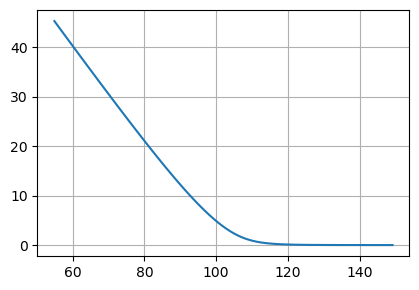

In [10]:
plt.plot(strike_array,opt_price)
plt.grid()

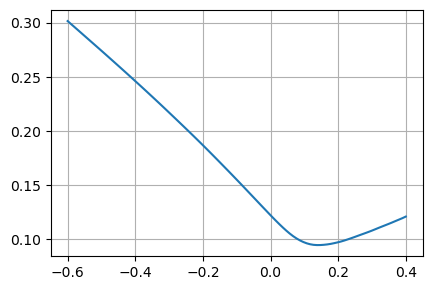

In [11]:
plt.plot(lm,iv)
plt.grid()

## Pricing VIX options

Recall that in variance curve models,
$$\text{VIX}_T = \frac{1}{\tau}\int_T^{T+\tau} \xi_T^u du$$
where $\tau=30/365$ (30 days). As a result, in the two-factor Bergomi model, there exists a function $\psi$ such that
$$\text{VIX}_T = \psi(T,X_T^1,X_T^2)$$
Write down the function $\psi$.

Since the vector $(X_T^1,X_T^2)$ is Gaussian, the price $\mathbb{E}[h(\text{VIX}_T)]$ of a VIX option $h(\text{VIX}_T)$ can be estimated by a Gauss-Hermite quadrature; see 
https://en.wikipedia.org/wiki/Gaussian_quadrature and 
https://numpy.org/doc/stable/reference/generated/numpy.polynomial.hermite.hermgauss.html

Using this method, price a VIX future maturing at $T$ (choose $T=1/12$ (1 month), $2/12$, $3/12$, $4/12$) and VIX call options with the same maturity; take strikes with log-moneyness from -0.2 to 2.5, based on the price of the VIX future. Vary the number of points in the quadrature. Plot the VIX smile, using the Black formula (with spot value the value of the VIX future) to compute the VIX implied volatilities. Comment on the impact of the vol-of-vol on the price of the VIX future and on the VIX implied volatilities; in the one-factor Bergomi model ($\theta=0$), comment on the impact of the mean reversion on the VIX implied volatilities.

By definition, $\text{VIX}^{2}_T = \frac{1}{\tau}\int_T^{T+\tau} \xi_T^u du$ where $\xi_t^u =\xi_0^u g^u(t,x_t^u) = \xi_0^u f^u(t,X_t^1,X_t^2)$.
$\newline$
With this equation in hand, one can easily write down $VIX$ as a function $\psi$ depending on $\left(T,X_T^1,X_T^2\right)$: $$\text{VIX}_T = \sqrt{\frac{1}{\tau}\int_T^{T+\tau} \xi_0^u f^u(T,X_T^1,X_T^2) du} = \Psi(T,X_T^1,X_T^2)$$ with $$\Psi(T,x,y) = \sqrt{\frac{1}{\tau}\int_T^{T+\tau} \xi_0^u f^u(T,x,y) du}$$

Through the several equations above one may code necessary functions as follows :

In [12]:
def covar(k_1, k_2, rho,t):
    return rho*(1-np.exp(-(k_1+k_2)*t))/(k_1+k_2)
   
def alpha(theta, rho): # so that vov actually is the variance's instantaneous log-normal volatility
    return ((1-theta)**2+theta*theta+2*rho*theta*(1-theta))**(-1/2) 

def x_t_u(t, u, theta, k1, k2, rho, xT1, xT2):
    return ((1-theta)*np.exp(-k1*(u-t))*xT1+theta*np.exp(-k2*(u-t))*xT2)*alpha(theta,rho)

def chi_t_u(t, u, theta, k1, k2, rho):
    α = alpha(theta,rho)
    return ((1-theta)**2*np.exp(-2*k1*(u-t))*covar(k1,k1,1,t)+theta**2*np.exp(-2*k2*(u-t))*covar(k2,k2,1,t)+ 2*(1-theta)*theta*np.exp(-(k1+k2)*(u-t))*covar(k1,k2,rho,t))*α**2

def g_u(t, u, x, vov, theta, k1, k2, rho):
    return np.exp(vov*x-vov**2/2*chi_t_u(t,u,theta,k1,k2,rho))

def xi_t_u(xi0, t, u, vov, theta, k1, k2, rho, xT1, xT2):
    x = x_t_u(t,u,theta,k1,k2,rho,xT1,xT2)
    return xi0*g_u(t,u,x,vov,theta,k1,k2,rho)

In [13]:
# parameters needed
τ = 30/365
T = [1/12,2/12,3/12,4/12]
logmoneyness_list = np.linspace(-0.2,2.5,30)

In [14]:
def psi(T,x1T,x2T,vov,theta,k1,k2,rho,u,v):
    u_temp = ((2*T+τ)/2)*np.ones(len(u))+(τ/2)*u
    x = xi_t_u(xi_0,T,u_temp,vov,theta,k1,k2,rho,x1T,x2T)
    return np.sqrt(1/2*np.dot(x,v))

## Future VIX calculation

In order to calculate $\mathbb{E}[\text{VIX}_{T}] = \mathbb{E}[\Psi(T,X_T^1,X_T^2)] = \mathbb{E}[\Psi_T(X_T^1,X_T^2)]$ a little theoritical introduction is necessary indeed. The idea here is to use the fact that :
$$(X_T^1,X_T^2) \sim \mathcal{N}(0,\Sigma)$$ 
$\newline$
where $$\Sigma = \begin{bmatrix}
\frac{1-e^{-2 k_1 T}}{2 k_1} & \rho_{1,2} \frac{1-e^{-(k_1+k_2) T}}{k_1+k_2} \\
\rho_{1,2} \frac{1-e^{-(k_1+k_2) T}}{k_1+k_2} & \frac{1-e^{-2 k_2 T}}{2 k_2}
\end{bmatrix}$$
$\newline$
Denoting by $R$ a square root of $\Sigma$ and $(U,V)$ a 2-dimensional canonical gaussian vector (just like it has already been studied in the first part), one may easily notice that : 
$R \begin{bmatrix} U \\ V
\end{bmatrix} \sim \begin{bmatrix} X_T^1 \\ X_T^2
\end{bmatrix}$

$\newline$
Now it is just about manipulation of some integrals and calculus as follows :
$\newline$
\begin{align*}
\mathbb{E}(VIX_{T}) &= \mathbb{E}(\Psi_T(X_T^1,X_T^2)) \\
&= \mathbb{E} \left(\Psi_T \left(R \left(U,V\right)\right)\right) \\
&= \int_{\mathbb{R}^{2}} \Psi_T(R(u,v)) \frac{1}{2 \pi} e^{-\frac{u^2}{2}} e^{-\frac{v^2}{2}} du dv \\
&= \frac{1}{\pi} \int_{\mathbb{R}^{2}} \left(\Psi_T \circ R\right) (\sqrt{2}u,\sqrt{2}v))e^{-u^2} e^{-v^2} du dv \\
&= \frac{1}{\pi} \int_{\mathbb{R}} e^{-u^2} \left(\int_{\mathbb{R}}  e^{-v^2} \left(\Psi_T \circ R\right) (\sqrt{2}u,\sqrt{2}v)) dv \right) du \\
\end{align*}

$\newline$
By using the Gauss Hermite quadrature method twice and introducing both weights and points $(w_i)_{i \in \mathbb{N}}$, $(x_i)_{i \in \mathbb{N}}$ one may obtain the following approximation :
$\newline$
\begin{align*}
\mathbb{E}(VIX_{T}) &\simeq \frac{1}{\pi} \int_{\mathbb{R}} e^{-u^2} \sum_{i=1}^{n} w_i \left(\Psi_T \circ R\right) (\sqrt{2}u,\sqrt{2}x_i)) du \\
&= \frac{1}{\pi} \sum_{i=1}^{n} w_i \int_{\mathbb{R}} e^{-u^2}  \left(\Psi_T \circ R\right) (\sqrt{2}u,\sqrt{2}x_i)) du \\
&\simeq \frac{1}{\pi} \sum_{i=1}^{n} w_i \sum_{j=1}^{n} w_j \left(\Psi_T \circ R\right) (\sqrt{2}x_{j},\sqrt{2}x_i))\\
&= \frac{1}{\pi} W^\intercal M W 
\end{align*}

where $$M = (\left(\Psi_T \circ R\right) (\sqrt{2}x_{i},\sqrt{2}x_j))_{(i,j) \in [1,n]^2}$$ $$W = \begin{bmatrix} w_1 \\ ... \\ w_n \end{bmatrix}$$

## Call on VIX calculation 

The payoff at time T of a call on VIX with strike K and maturity T is : $(\text{VIX}_T - K)_{+}$. Its price at time 0 is given by :
$\newline$
\begin{align*}
\mathbb{E}(\text{VIX}_T - K)_{+}) &= \mathbb{E}(\Psi_{T}(X_T^1,X_T^2) - K)_{+}) \\
&= \mathbb{E}(\Lambda_{T}(X_T^1,X_T^2) \\
\end{align*}
$\newline$
with $\Lambda_{T}(x,y) = (\Psi_{T}(x,y) - K)_{+}$
If a call on VIX with maturity $T$ and strike $K$ is denoted by $C(T,K)$, then by following the same steps (approximation and calculation) as future VIX calculation actually leads to the following result :
$\newline$
\begin{align*}
C(T,K) = \frac{1}{\pi} W^\intercal \tilde{M} W 
\end{align*}

where $$\tilde{M} = (\left(\Lambda_T \circ R\right) (\sqrt{2}x_{i},\sqrt{2}x_j))_{(i,j) \in [1,n]^2}$$ $$W = \begin{bmatrix} w_1 \\ ... \\ w_n \end{bmatrix}$$


## Future VIX implementation 

In [15]:
def future_vix(T, xi_0, vov, k_1, k_2, rho_x1x2, deg):
    cov_matrix = np.array([[covar(k_1,k_1,1,T),covar(k_1,k_2,rho_x1x2,T)], [covar(k_1,k_2,rho_x1x2,T),covar(k_2,k_2,1,T)]]) 
    R = np.linalg.cholesky(cov_matrix)
    u,v = np.polynomial.legendre.leggauss(deg) # using Gauss-Legendre polynomes
    X, W = np.polynomial.hermite.hermgauss(deg) # using Gauss-Hermite quadrature
    mat = np.zeros((len(X),len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            x, y = np.sqrt(2)*np.dot(R,np.array([X[i],X[j]]))
            temp = psi(T, x, y, vov, theta, k_1, k_2, rho_x1x2, u, v)
            mat[i,j] = temp
    return np.dot(np.transpose(W),np.dot(mat,W))/np.pi

In [16]:
future_vix_list = [future_vix(t,xi_0,vov,k_1,k_2,rho_x1x2,150) for t in T]

## Call on VIX implementation 

In [17]:
def call_vix(k, T, future, xi_0, vov, k_1, k_2, rho_x1x2, deg_leg, deg_herm):
    cov_matrix = np.array([[covar(k_1,k_1,1,T),covar(k_1,k_2,rho_x1x2,T)],[covar(k_1,k_2,rho_x1x2,T),covar(k_2,k_2,1,T)]])
    R = np.linalg.cholesky(cov_matrix)
    u, v = np.polynomial.legendre.leggauss(deg_leg)
    X, W =np.polynomial.hermite.hermgauss(deg_herm)
    mat = np.zeros((len(X),len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            x, y = np.sqrt(2)*np.dot(R,np.array([X[i],X[j]]))
            temp = max(psi(T,x,y,vov,theta,k_1,k_2,rho_x1x2,u,v)-future*np.exp(k),0)
            mat[i,j]= temp
    return np.dot(np.transpose(W),np.dot(mat,W))/np.pi

In [18]:
call_list = []
vol_list  = []
for i in range(len(T)):
    call_temp = np.array([call_vix(k,T[i],future_vix_list[i],xi_0,vov,k_1,k_2,rho_x1x2,200,200) for k in logmoneyness_list])
    vol_temp  = vec_find_vol_rat(call_temp, future_vix_list[i], future_vix_list[i]*np.exp(logmoneyness_list), T[i], 0, 'c')
    call_list.append(call_temp)
    vol_list.append(vol_temp)

## Graphs analysis 

### Future VIX as a function of time to maturity 

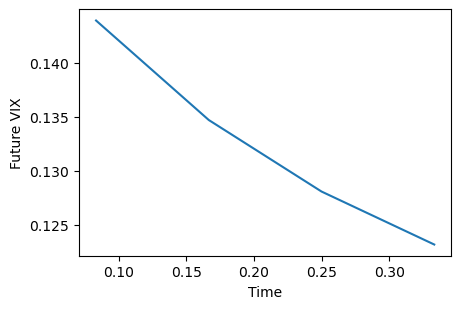

In [19]:
plt.plot(T,future_vix_list)
plt.xlabel("Time")
plt.ylabel("Future VIX")
plt.show()

Text(0.5, 1.0, 'Implied volatility')

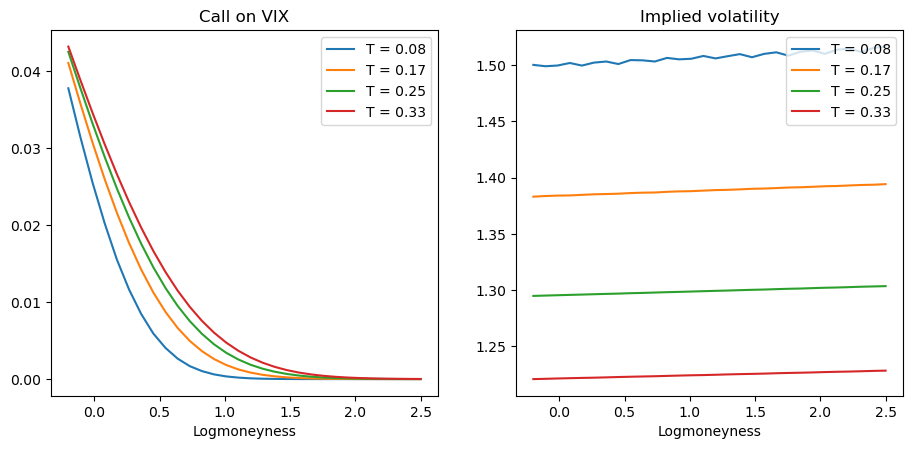

In [20]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
for i in range(len(T)) :
    axs[0].plot(logmoneyness_list, call_list[i], label='T = ' + str(np.round(T[i],2)))
    axs[1].plot(logmoneyness_list, vol_list[i], label ='T = ' + str(np.round(T[i],2)))

for ax in axs:
    ax.set_xlabel('Logmoneyness')
    ax.legend(loc=0)

axs[0].set_title('Call on VIX')
axs[1].set_title('Implied volatility')

### Impact of the vol-of-vol on the price of the VIX future and on the VIX implied volatilities

In [21]:
vov_list = np.linspace(3,5,6) # centered on VoV = 4

future_vix_mat = np.array([[future_vix(t,xi_0,vov,k_1,k_2,rho_x1x2,150) for t in T] for vov in vov_list])
call_mat = np.array([[call_vix(k,T[0],future_vix_mat[i,0],xi_0,vov_list[i],k_1,k_2,rho_x1x2,200,200) for k in logmoneyness_list] for i in range(len(vov_list))])
vol_mat  = np.array([[vec_find_vol_rat(call_mat[i,k], future_vix_mat[i,0], future_vix_mat[i,0]*np.exp(logmoneyness_list[k]), T[0], 0, 'c') for k in range(len(logmoneyness_list))] for i in range(len(vov_list))]) # time to maturity fixed and equals to 1/12

Text(0.5, 1.0, 'Implied volatility')

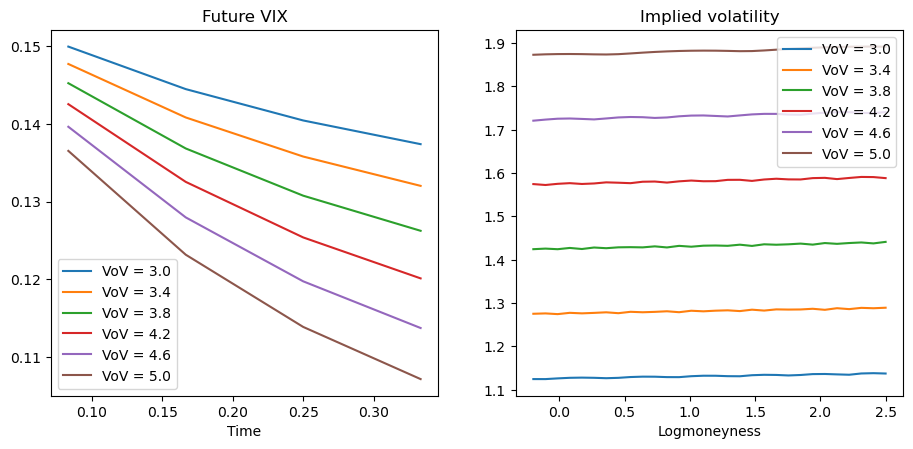

In [22]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
for i in range(6):
    axs[0].plot(T, future_vix_mat[i],label='VoV = ' + str(np.round(vov_list[i],1)))
    axs[1].plot(logmoneyness_list, vol_mat[i], label ='VoV = ' + str(np.round(vov_list[i],1)))

for ax in axs:
    ax.legend(loc=0)
               
axs[0].set_xlabel('Time')
axs[0].set_title('Future VIX')
axs[1].set_xlabel('Logmoneyness')           
axs[1].set_title('Implied volatility')

### Impact of the mean reversion on the VIX implied volatilities

In [28]:
# parameters needed
theta = 0
vov   = 4 # as the initial value we set
k_list = np.linspace(3,5,6) # centered on k = 4 that actually corresponds to 3 months

In [29]:
# calculation, suffix '_k' stands for variable as a function of k_list not to use the same variable names as above
future_vix_mat_k = np.array([[future_vix(t,xi_0,vov,k_temp,k_2,rho_x1x2,150) for t in T] for k_temp in k_list])
call_mat_k       = np.array([[call_vix(k,T[0],future_vix_mat_k[i,0],xi_0,vov,k_temp,k_2,rho_x1x2,200,200) for k in logmoneyness_list] for k_temp in k_list])
vol_mat_k        = np.array([[vec_find_vol_rat(call_mat_k[i,k], future_vix_mat_k[i,0], future_vix_mat_k[i,0]*np.exp(logmoneyness_list[k]), T[0], 0, 'c') for k in range(len(logmoneyness_list))] for i in range(len(k_list))])

Text(0.5, 1.0, 'Implied volatility')

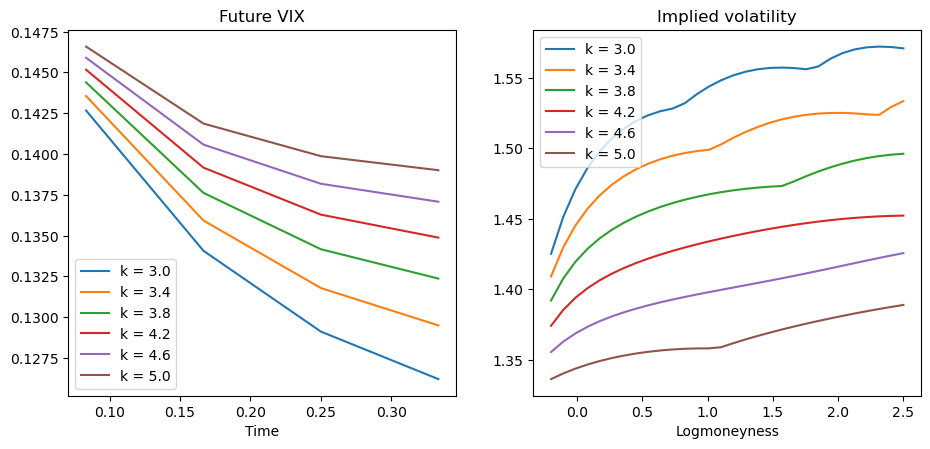

In [32]:
fig, axs = plt.subplots(1,2, figsize=(11, 4.75))
for i in range(6):
    axs[0].plot(T, future_vix_mat_k[i], label='k = ' + str(np.round(k_list[i],1)))
    axs[1].plot(logmoneyness_list, vol_mat_k[i], label ='k = ' + str(np.round(k_list[i],1)))

for ax in axs:
    ax.legend(loc=0)
               
axs[0].set_xlabel('Time')
axs[0].set_title('Future VIX')
axs[1].set_xlabel('Logmoneyness')           
axs[1].set_title('Implied volatility')